## Correlation between mainshocks and surface mass loading

#### - declustered with Mizrahi's ETAS code

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from global_land_mask import globe
import scipy.stats as stats
import os
import importlib
import geopandas as gpd

# file containing functions:
import loadquakes

In [2]:
# Load datasets
dataset_path = '/data/fast1/surface-load/'
ds = xr.open_dataset(dataset_path + "GRCTellus.JPL.200204_202102.GLO.RL06M.MSCNv02CRI.nc")
# catalog = pd.read_csv('eq_200204_202102.csv')
catalog = pd.read_csv(dataset_path + 'ind_and_bg_probs.csv')
catalog["time"] = catalog["time"].astype("datetime64")

In [3]:
rates = ds['lwe_thickness'].diff('time')
rates.name = 'loading_rate'
ds['loading_rate'] = rates

In [201]:
ds['time']

<xarray.DataArray 'time' (time: 194)>
array(['2002-04-17T12:00:00.000000000', '2002-05-10T12:00:00.000000000',
       '2002-08-16T12:00:00.000000000', '2002-09-16T00:00:00.000000000',
       '2002-10-16T12:00:00.000000000', '2002-11-16T00:00:00.000000000',
       '2002-12-16T12:00:00.000000000', '2003-01-16T12:00:00.000000000',
       '2003-02-15T00:00:00.000000000', '2003-03-16T12:00:00.000000000',
       '2003-04-16T00:00:00.000000000', '2003-05-11T12:00:00.000000000',
       '2003-07-16T12:00:00.000000000', '2003-08-16T12:00:00.000000000',
       '2003-09-16T00:00:00.000000000', '2003-10-16T00:00:00.000000000',
       '2003-11-16T00:00:00.000000000', '2003-12-16T12:00:00.000000000',
       '2004-01-07T12:00:00.000000000', '2004-02-17T00:00:00.000000000',
       '2004-03-16T12:00:00.000000000', '2004-04-16T00:00:00.000000000',
       '2004-05-16T12:00:00.000000000', '2004-06-16T00:00:00.000000000',
       '2004-07-16T12:00:00.000000000', '2004-08-16T12:00:00.000000000',
       '2004-09-16T00:00:00.000000000', '2004-10-16T12:00:00.000000000',
       '2004-11-16T00:00:00.000000000', '2004-12-16T12:00:00.000000000',
       '2005-01-16T12:00:00.000000000', '2005-02-15T00:00:00.000000000',
       '2005-03-16T12:00:00.000000000', '2005-04-16T00:00:00.000000000',
       '2005-05-16T12:00:00.000000000', '2005-06-16T00:00:00.000000000',
       '2005-07-16T12:00:00.000000000', '2005-08-16T12:00:00.000000000',
       '2005-09-16T00:00:00.000000000', '2005-10-16T12:00:00.000000000',
       '2005-11-16T00:00:00.000000000', '2005-12-16T12:00:00.000000000',
       '2006-01-16T12:00:00.000000000', '2006-02-15T00:00:00.000000000',
       '2006-03-16T12:00:00.000000000', '2006-04-16T00:00:00.000000000',
       '2006-05-16T12:00:00.000000000', '2006-06-16T00:00:00.000000000',
       '2006-07-16T12:00:00.000000000', '2006-08-16T12:00:00.000000000',
       '2006-09-16T00:00:00.000000000', '2006-10-16T12:00:00.000000000',
       '2006-11-16T00:00:00.000000000', '2006-12-16T12:00:00.000000000',
       '2007-01-16T12:00:00.000000000', '2007-02-15T00:00:00.000000000',
       '2007-03-16T12:00:00.000000000', '2007-04-16T00:00:00.000000000',
       '2007-05-16T12:00:00.000000000', '2007-06-16T00:00:00.000000000',
       '2007-07-16T12:00:00.000000000', '2007-08-16T12:00:00.000000000',
       '2007-09-16T00:00:00.000000000', '2007-10-16T12:00:00.000000000',
       '2007-11-16T00:00:00.000000000', '2007-12-16T12:00:00.000000000',
       '2008-01-16T12:00:00.000000000', '2008-02-15T12:00:00.000000000',
       '2008-03-16T12:00:00.000000000', '2008-04-16T00:00:00.000000000',
       '2008-05-16T12:00:00.000000000', '2008-06-16T00:00:00.000000000',
       '2008-07-16T12:00:00.000000000', '2008-08-16T12:00:00.000000000',
       '2008-09-16T00:00:00.000000000', '2008-10-16T12:00:00.000000000',
       '2008-11-16T00:00:00.000000000', '2008-12-16T12:00:00.000000000',
       '2009-01-16T12:00:00.000000000', '2009-02-15T00:00:00.000000000',
       '2009-03-16T12:00:00.000000000', '2009-04-16T00:00:00.000000000',
       '2009-05-16T12:00:00.000000000', '2009-06-16T00:00:00.000000000',
       '2009-07-16T12:00:00.000000000', '2009-08-16T12:00:00.000000000',
       '2009-09-16T00:00:00.000000000', '2009-10-16T12:00:00.000000000',
       '2009-11-16T00:00:00.000000000', '2009-12-16T12:00:00.000000000',
       '2010-01-16T12:00:00.000000000', '2010-02-15T00:00:00.000000000',
       '2010-03-16T12:00:00.000000000', '2010-04-16T00:00:00.000000000',
       '2010-05-16T12:00:00.000000000', '2010-06-16T00:00:00.000000000',
       '2010-07-16T12:00:00.000000000', '2010-08-16T12:00:00.000000000',
       '2010-09-16T00:00:00.000000000', '2010-10-16T12:00:00.000000000',
       '2010-11-16T00:00:00.000000000', '2010-12-14T12:00:00.000000000',
       '2011-02-18T12:00:00.000000000', '2011-03-16T12:00:00.000000000',
       '2011-04-16T00:00:00.000000000', '2011-05-16T12:00:00.000000000',
       '2011-07-18T12:00:00.000000000', '2011-08-16T12:00:00.000000000',
       '2011-09-16T0

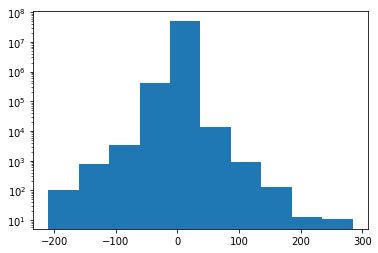

In [5]:
# Loading rate during all time periods

fig,ax=plt.subplots()
fig.patch.set_facecolor('w')
plt.hist(ds['loading_rate'].data.flatten())
plt.yscale('log')

In [6]:
mainshock = catalog[catalog['P_triggered']<.9]
mainshock

,target_id,latitude,longitude,time,magnitude,geometry,mu,P_triggered,P_background
49,53,2.6675,-59.5879,2021-01-31 19:05:14.367,5.5,POINT (2.6675 -59.5879),8.774521e-11,0.081552,0.918448
50,54,-13.9672,121.8641,2021-01-29 19:47:55.783,5.7,POINT (-13.9672 121.8641),8.774521e-11,0.634690,0.365310
54,58,18.2516,-64.0708,2021-01-24 23:21:41.140,5.4,POINT (18.2516 -64.07080000000001),8.774521e-11,0.829974,0.170026
73,77,-37.1225,-17.2548,2021-01-15 10:45:21.876,5.6,POINT (-37.1225 -17.2548),8.774521e-11,0.871333,0.128667
80,84,51.2811,100.4383,2021-01-11 21:32:59.015,6.7,POINT (51.2811 100.4383),8.774521e-11,0.729328,0.270672
...,...,...,...,...,...,...,...,...,...
9426,9430,84.2530,0.4080,2006-02-14 00:39:49.590,5.4,POINT (84.25299999999999 0.408),8.774521e-11,0.488028,0.511972
9427,9431,-62.2100,-158.1880,2006-02-13 03:23:35.610,5.4,POINT (-62.21 -158.188),8.774521e-11,0.878727,0.121273
9436,9440,66.2968,-142.6856,2006-02-05 08:17:01.373,5.4,POINT (66.2968 -142.6856),8.774521e-11,0.494733,0.505267
9437,9441,1.0930,-90.4600,2006-02-04 09:17:04.090,5.9,POINT (1.093 -90.45999999999999),8.774521e-11,0.700162,0.299838


In [7]:
pd.options.mode.chained_assignment = None

In [8]:
def get_mass(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["lwe_thickness"]
    return mass_change.data

def get_mass_rate(eq):
    mass_change = ds.sel(lat=(eq["latitude"]),lon=(eq["longitude"]),time=(eq["time"]), method="nearest")
    mass_change = mass_change["loading_rate"]
    return mass_change.data
  
mainshock['dmass'] = mainshock.apply(lambda row: get_mass(row), axis=1)
mainshock['loading_rate'] = mainshock.apply(lambda row: get_mass_rate(row), axis=1)

In [9]:
mainshock.loading_rate

49      -0.20319548786804997
50        0.8412606154982991
54        0.4186036157226365
73       -0.7553214435727118
80        0.6889384420543379
                ...         
9426    -0.23154228528011256
9427     -3.4268429011605965
9436    -0.26713710369289245
9437      0.7191034405071668
9446      0.7045291303748303
Name: loading_rate, Length: 510, dtype: object

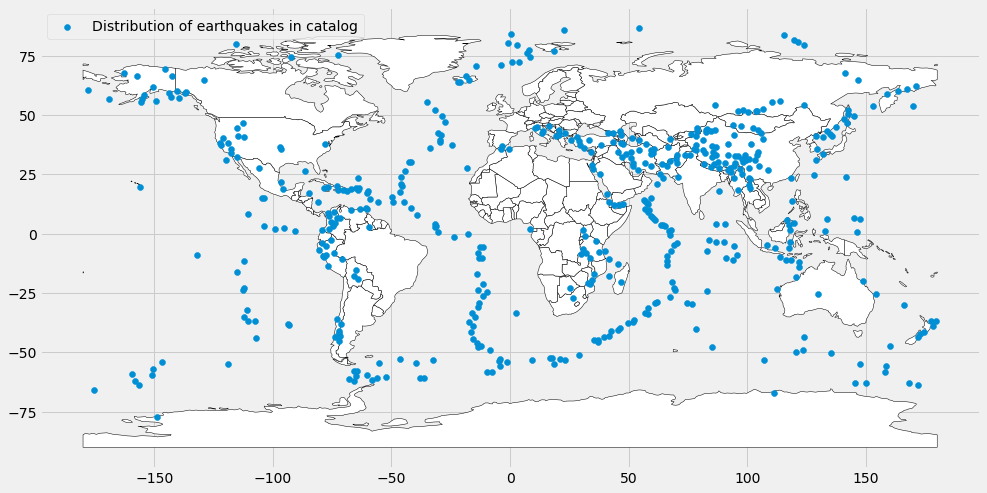

In [218]:
# Distribution of all mainshocks

gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy(mainshock.longitude, mainshock.latitude))
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(15,10))
gdf.plot(ax=ax, label='Distribution of earthquakes in catalog')
leg = ax.legend()

In [220]:
importlib.reload(loadquakes)

<module 'loadquakes' from '/home/amand4/notebooks/surface-load-quakes/loadquakes.py'>

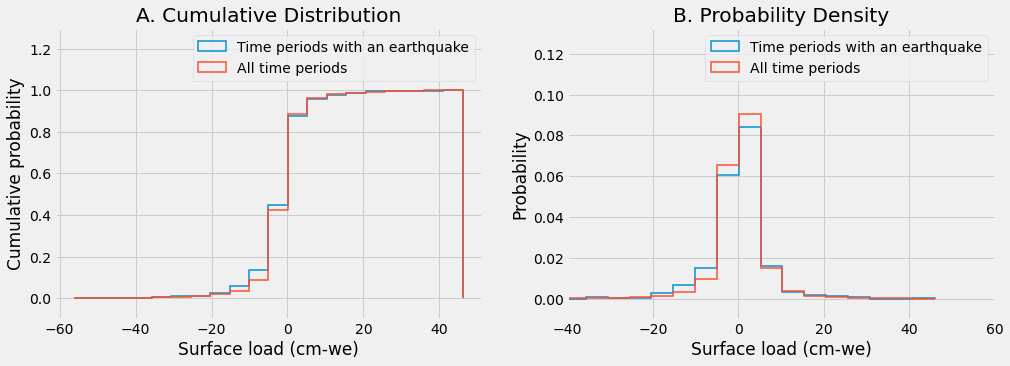

In [215]:
fig,(ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
plt.style.use('fivethirtyeight')

loadquakes.plot_hist(np.array(ds['lwe_thickness'].data.flatten()), np.array(mainshock.dmass), ax1, ax2, 
              'A. Cumulative Distribution', 'B. Probability Density')

In [216]:
# takes very long time to load:

# loadquakes.calc_stats(np.array(mainshock.dmass),np.array(ds['lwe_thickness'].data.flatten()))

## Using Bayes' Theorem:

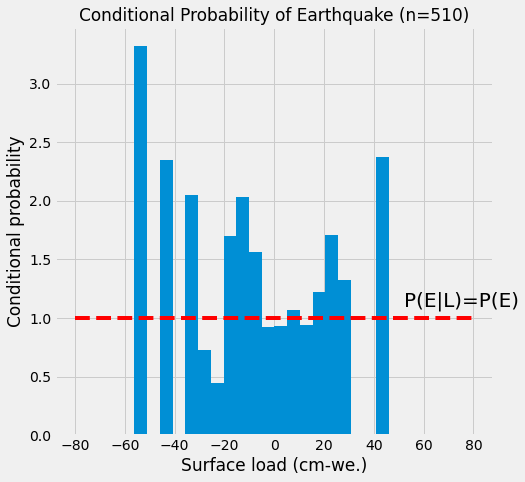

In [244]:
fig,ax = plt.subplots(figsize=(7,7))

loadquakes.plot_rel_hist(np.array(ds['lwe_thickness'].data.flatten()), np.array(mainshock.dmass), ax, 
              'Conditional Probability of Earthquake (n=510)')

## Mapping earthquakes with high conditional probability

In [15]:
def high_cond_prob(earthquake_only, all_time_periods, bins):
    
    LgE = np.histogram(earthquake_only, bins=bins, density = True)[0]
    L   = np.histogram(all_time_periods,bins=bins, density = True)[0]
    
    which_bin = np.digitize(earthquake_only,bins)
    height = LgE/L
    high_cond_prob = height[height > 2]
    
    indices = np.where(np.in1d(height, high_cond_prob))[0]
     
    print("Bin number =")
    print(indices)
    
    print("Surface load = ")
    for i in range(len(indices)):
        print("Between")
        print(bins[indices[i-1]])
        print("and")
        print(bins[indices[i-1]+1])
        
    print("Corresponding bin height = ")
    for i in range(len(indices)):
        print(height[indices[i-1]])

In [16]:
# np.where(height > 2)

In [18]:
conditional_probability = loadquakes.get_cond_probability(
                            np.array(ds['lwe_thickness'].data.flatten()),
                            np.array(mainshock.dmass), np.array(mainshock.dmass))

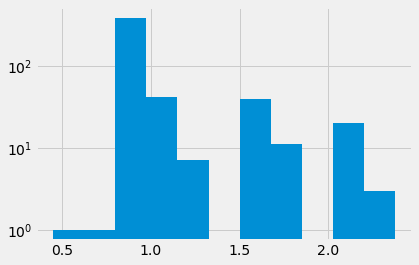

In [35]:
mainshock['cp'] = conditional_probability
fig,ax=plt.subplots()
plt.hist(np.array(mainshock['cp']),11)
plt.yscale('log')

In [441]:
mainshock[mainshock.cp > 1.5].sort_values('cp')

,target_id,latitude,longitude,time,magnitude,geometry,mu,P_triggered,P_background,dmass,loading_rate,cp,cp_rate
96,100,45.4244,16.2573,2020-12-29 11:19:54.762,6.4,POINT (45.4244 16.2573),8.774521e-11,0.482102,0.517898,-9.147033521271725,6.413889408111572,1.933115,0.918168
8569,8573,6.7050,-72.9460,2007-05-06 04:47:13.680,5.4,POINT (6.705 -72.946),8.774521e-11,0.488851,0.511149,-13.613113423770603,4.062651813030243,1.933115,0.918168
7668,7672,32.3080,47.3500,2008-08-27 21:52:38.110,5.8,POINT (32.308 47.35),8.774521e-11,0.594874,0.405126,-11.256055178099452,-1.478222969994814,1.933115,1.070847
7251,7255,10.2000,-67.0100,2009-05-04 09:10:20.900,5.5,POINT (10.2 -67.01000000000001),8.774521e-11,0.215597,0.784403,-9.154859835966668,-8.060158618994919,1.933115,0.981120
6848,6852,-10.1260,33.8700,2009-12-06 17:36:36.010,5.8,POINT (-10.126 33.87),8.774521e-11,0.115178,0.884822,-10.152200832095774,1.4800200222292634,1.933115,0.918168
6263,6267,29.6370,51.6660,2010-09-27 11:22:45.180,5.9,POINT (29.637 51.666),8.774521e-11,0.644536,0.355464,-12.114044823696734,-2.5889468789100647,1.933115,1.070847
5311,5315,54.0800,123.7220,2011-10-14 06:10:14.600,6.0,POINT (54.08 123.722),8.774521e-11,0.215246,0.784754,-10.280844932385095,-0.950025177566177,1.933115,1.070847
5286,5290,43.6480,82.4370,2011-11-01 00:21:28.090,5.6,POINT (43.648 82.43700000000003),8.774521e-11,0.820011,0.179989,-8.56590858111263,1.4022699040670297,1.933115,0.918168
4923,4927,27.7670,100.7810,2012-06-24 07:59:34.860,5.5,POINT (27.767 100.781),8.774521e-11,0.703564,0.296436,-8.413567208872262,8.433012122002271,1.933115,1.626105
4917,4921,43.4330,84.7000,2012-06-29 21:07:33.860,6.3,POINT (43.433 84.7),8.774521e-11,0.754831,0.245169,-13.59261216616419,0.9014975451830516,1.933115,0.918168


No handles with labels found to put in legend.


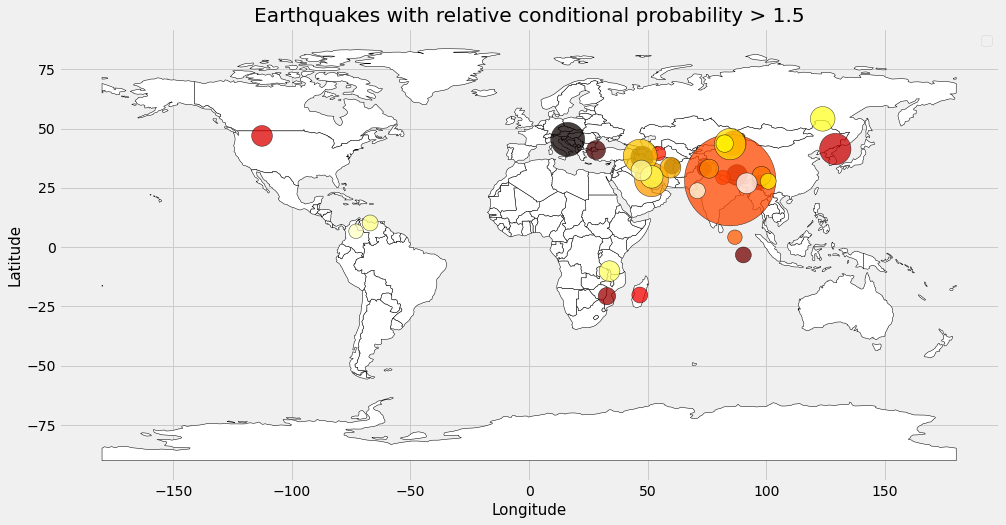

In [387]:
load_bounds = mainshock[mainshock['cp']>1.5]

def probability_map(load_bounds,color,label):

    gdf = gpd.GeoDataFrame(load_bounds,
                           geometry=gpd.points_from_xy(load_bounds.longitude, load_bounds.latitude))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))

    pl=gdf.plot(ax=ax, markersize = 1e-5*load_bounds.magnitude**10, 
             c = color/max(color), alpha=0.75, cmap='hot',
                edgecolor='k',legend=True)
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    leg = ax.legend()
    ax.set_title(label)
    plt.show()

probability_map(load_bounds,load_bounds.cp,
                'Earthquakes with relative conditional probability > 1.5')

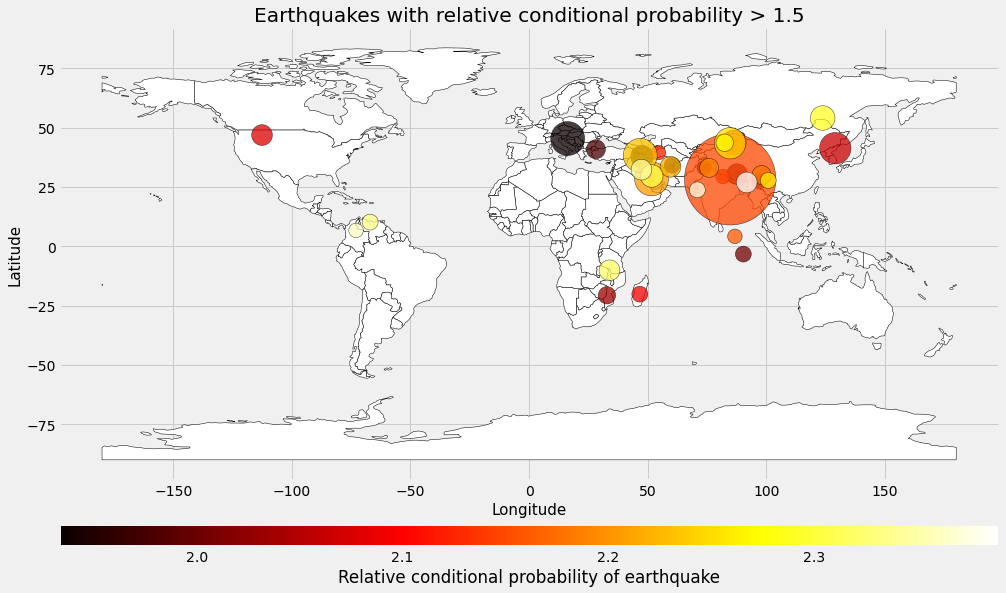

In [439]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
load_bounds = mainshock[mainshock['cp']>1.5]

def probability_map_cb(load_bounds,color,label):

    gdf = gpd.GeoDataFrame(load_bounds,
                           geometry=gpd.points_from_xy(load_bounds.longitude, 
                                                       load_bounds.latitude))
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    ax = world.plot(color='white', edgecolor='black', figsize=(15,10))

    gdf.plot(ax=ax, markersize = 1e-5*load_bounds.magnitude**10, 
             c=load_bounds.cp, alpha=0.75, cmap='hot',
                edgecolor='k',legend=True)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="5%", pad=0.6)
    gdf.plot(ax=ax,cax=cax,alpha=0.01,column=color,cmap='hot',legend=True,
            legend_kwds={'label': "Relative conditional probability of earthquake",
                            'orientation': "horizontal"})
    ax.set_xlabel('Longitude', fontsize = 15)
    ax.set_ylabel("Latitude", fontsize = 15)
    ax.set_title(label)
    plt.show()

probability_map_cb(load_bounds,load_bounds.cp,
                'Earthquakes with relative conditional probability > 1.5')

In [405]:
load_bounds.cp

96      1.933115
604     1.933115
689     2.390123
747     1.933115
753     1.933115
1059    1.933115
1173    1.933115
1176    1.933115
1219    1.933115
1959    1.933115
2029    1.933115
2243    1.933115
2334    1.933115
2408    1.933115
2879    1.933115
3284    1.933115
3930    1.933115
4265    1.933115
4410    1.933115
4449    1.933115
4668    1.933115
4855    1.933115
4917    1.933115
4923    1.933115
5286    1.933115
5311    1.933115
6263    1.933115
6848    1.933115
7251    1.933115
7668    1.933115
8569    1.933115
9393    1.933115
9414    1.933115
Name: cp, dtype: float64

In [54]:
# high_cond_prob(np.array(mainshock.dmass),
#                np.array(ds['lwe_thickness'].data.flatten()),bins)

In [ ]:
# importlib.reload(loadquakes)

In [56]:
# loadquakes.plot_same_map(mainshock['dmass'],mainshock['dmass'],
#              mainshock[(44 < mainshock['dmass']) & (mainshock['dmass'] < 48)],
#              mainshock[(-60 < mainshock['dmass']) & (mainshock['dmass'] < -56)],
#              'Earthquakes that occured between surface load 44 and 48',
#              'Earthquakes that occured between surface load -60 and -56')

In [58]:
# mainshock[mainshock['dmass'] < -40]

In [60]:
# high_cond_prob(D_eq_values[0],D_values[0],bins)

# Analysis for rates of loading

In [183]:
loadquakes.calc_stats(np.array(mainshock.loading_rate),np.array(ds['loading_rate'].data.flatten()))

{'cvm': CramerVonMisesResult(statistic=25093717328.75074, pvalue=0.0025406388631654675),
 'ks': KstestResult(statistic=0.04258563340857535, pvalue=0.3046628046046259),
 'median_all': nan,
 'median_eq': -0.1252215765497109,
 'mean_all': nan,
 'mean_eq': 0.0894192610713478,
 'mean_all_minus_mean_eq': nan,
 'median_all_minus_median_eq': nan}

In [197]:
np.nanmean(np.array(ds['loading_rate'].data.flatten()))

-0.012434669938479264

In [196]:
np.nanmedian(np.array(ds['loading_rate'].data.flatten()))

0.008514266641716284

In [225]:
importlib.reload(loadquakes)

<module 'loadquakes' from '/home/amand4/notebooks/surface-load-quakes/loadquakes.py'>

In [372]:
loadquakes.plot_hist_rate(ds['loading_rate'].data.flatten(), 
                          mainshock.loading_rate, ax1, ax2, "test","test")

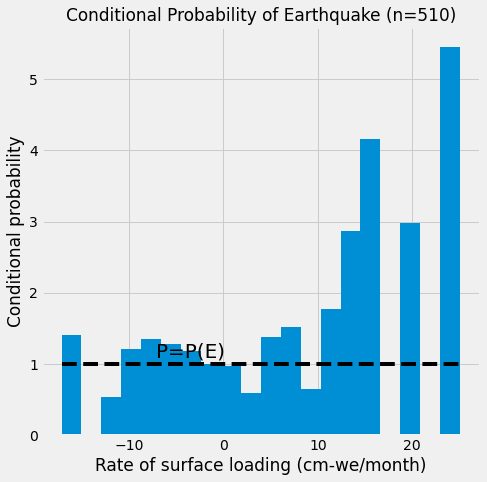

In [223]:
loadquakes.plot_rel_hist_rate(ds['loading_rate'].data.flatten(), 
                              mainshock.loading_rate, ax, 
                              'Conditional Probability of Earthquake (n=510)')

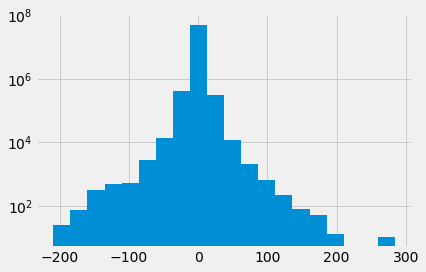

In [63]:
fig,ax=plt.subplots()
plt.hist(ds['loading_rate'].data.flatten(),20 )
plt.yscale('log')

In [65]:
conditional_probability_rate = loadquakes.get_cond_probability(
                                    np.array(ds['loading_rate'].data.flatten()),
                                    np.array(mainshock.loading_rate),
                                    np.array(mainshock.loading_rate))

mainshock['cp_rate'] = conditional_probability_rate

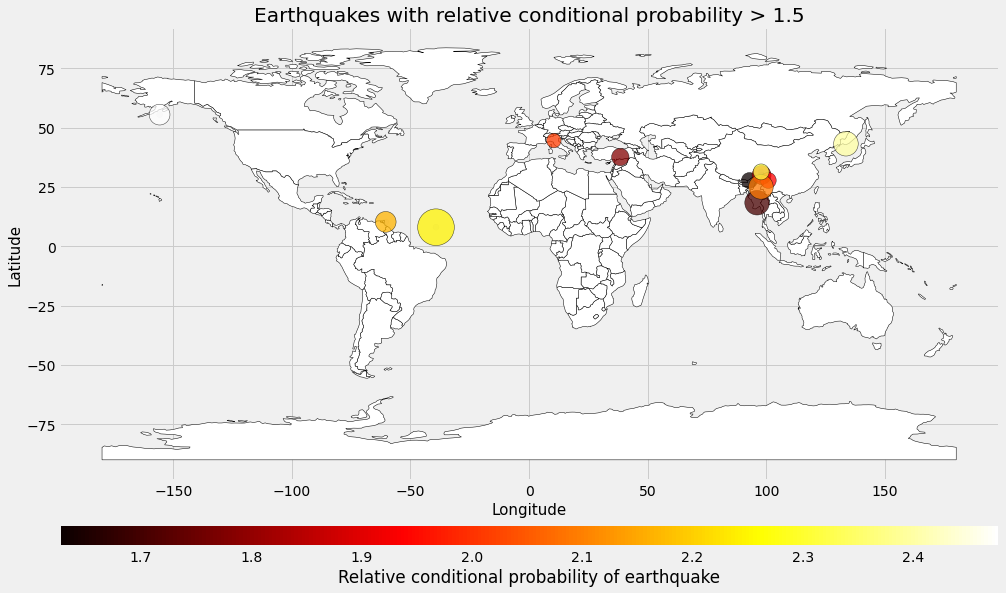

In [440]:
load_bounds = mainshock[mainshock['cp_rate']>1.5]

probability_map_cb(load_bounds,load_bounds.cp_rate,
                'Earthquakes with relative conditional probability > 1.5')

## Figures for paper

In [324]:
def set_of_figures_load(all_time, earthquake_only):

    fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,5))

    plt.style.use('fivethirtyeight')
    loadquakes.plot_hist(all_time, earthquake_only, ax1, ax2, 
              'A. Cumulative Distribution', 'B. Probability Density')

    loadquakes.plot_rel_hist(all_time, earthquake_only, ax3, 
                  'C. Bayesian Probability of Earthquake (n=510)')

    fig.tight_layout()

In [325]:
def set_of_figures_rate(all_time, earthquake_only):

    fig,(ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(20,5))

    plt.style.use('fivethirtyeight')
    loadquakes.plot_hist_rate(all_time, earthquake_only, ax1, ax2, 
              'A. Cumulative Distribution', 'B. Probability Density')

    loadquakes.plot_rel_hist_rate(all_time, earthquake_only, ax3, 
                  'C. Bayesian Probability of Earthquake (n=510)')

    fig.tight_layout()

In [326]:
importlib.reload(loadquakes)

<module 'loadquakes' from '/home/amand4/notebooks/surface-load-quakes/loadquakes.py'>

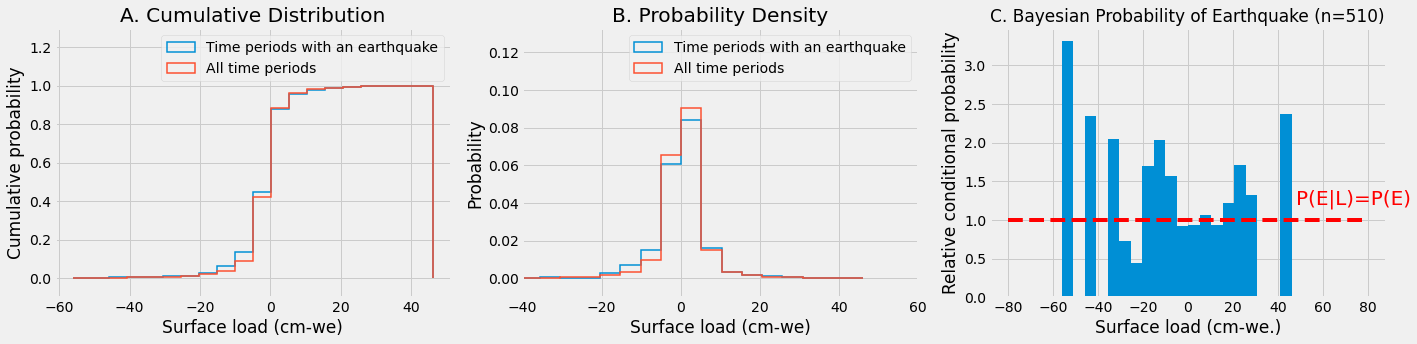

In [327]:
set_of_figures_load(ds['lwe_thickness'].data.flatten(), mainshock.dmass)

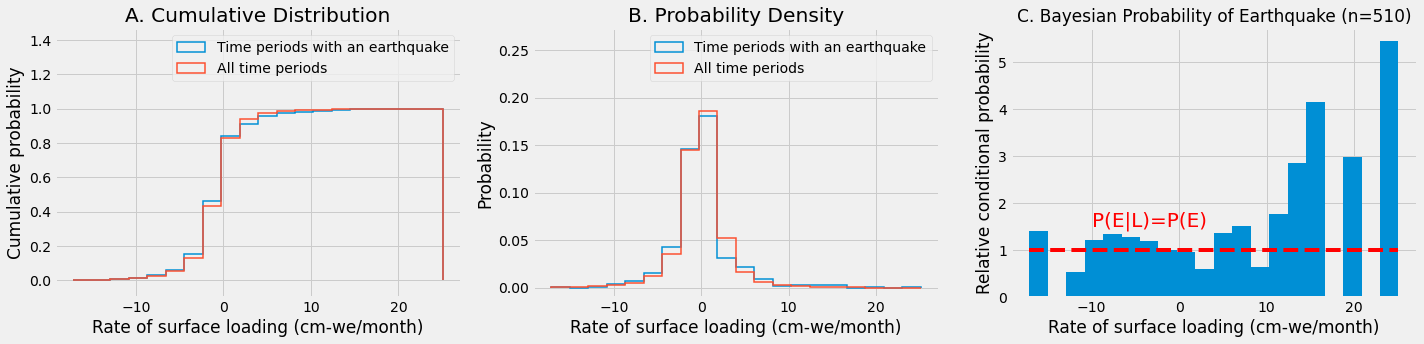

In [328]:
set_of_figures_rate(ds['loading_rate'].data.flatten(), mainshock.loading_rate)